## Soil moisture evolution Schwarzwald (2015- 2022)

1. Map of the Harz Region 
2. Selections of Grid cells for the precipitation, radiation, tempertature and LAI data
3. Running the simple water balance model for the years 2015 to 2022 for the Harz region
4. Make a soil moisture evolution diagramm

### Importing packages 

In [1]:
import folium
import os
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import shutil
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap
import final_model

# Import libraries
from matplotlib import pyplot as plt
import numpy as np
import netCDF4 as nc
import pandas as pd
import xarray as xr
import run

### Reading data

### Map of the Harz region and selection of grid cells

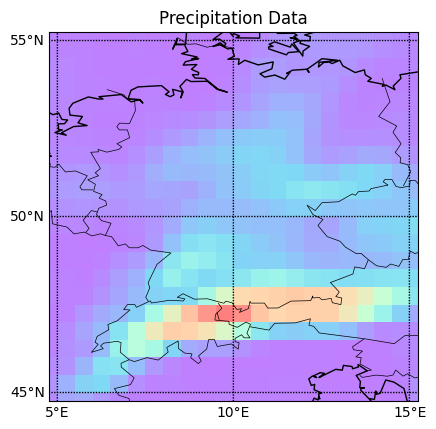

In [2]:
# File paths
precipitation_file = "data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.2000.nc"

# Open the NetCDF file
nc_file = nc.Dataset(precipitation_file)
lon = nc_file.variables['lon'][:]
lat = nc_file.variables['lat'][:]
data = nc_file.variables['tp'][50, :, :]  # Using arbitrary time index 50

# Create Basemap instance
m = Basemap(llcrnrlon=lon.min(), llcrnrlat=lat.min(),
            urcrnrlon=lon.max(), urcrnrlat=lat.max(),
            projection='cyl', resolution='l')

# Draw coastlines, countries, and states
m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Plot the precipitation data as grid cells
x_mesh, y_mesh = np.meshgrid(lon, lat)
x_mesh, y_mesh = m(x_mesh, y_mesh)
plt.pcolormesh(x_mesh, y_mesh, data, cmap='rainbow', alpha=0.5, label='Precipitation Data')

# Add latitude and longitude lines with labels
m.drawparallels(np.arange(-90., 91., 5.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 5.), labels=[0,0,0,1], fontsize=10)

plt.title('Precipitation Data')

# Show the plot
plt.show()

# Close the NetCDF file
nc_file.close()

### Schwarzwald

In [3]:
import folium
import geopandas as gpd

# File path to the Harz shapefile
shapefile_path = "data/schwarzwald_naturpark/naturpark_schwarzwald.shp"

# Load the shapefile using geopandas
schwarzwald_shape = gpd.read_file(shapefile_path, encoding='latin1')

# Create a Folium map
m = folium.Map()

# Add the shapefile to the map
folium.GeoJson(schwarzwald_shape).add_to(m)

# Display the map
m

In [4]:
import geopandas as gpd
from shapely.geometry import box

# File path to the Schwarzwald shapefile
shapefile_path = "data/schwarzwald_naturpark/naturpark_schwarzwald.shp"

# Load the shapefile using geopandas
schwarzwald_shape = gpd.read_file(shapefile_path, encoding='latin1')

# Define the CRS of the shapefile (EPSG:32632)
original_crs = {'init': 'epsg:32632'}

# Convert the bounds to degrees (latitude and longitude)
bounds_deg = schwarzwald_shape.total_bounds
bounds_deg = gpd.GeoSeries([box(bounds_deg[0], bounds_deg[1], bounds_deg[2], bounds_deg[3])], crs=original_crs).to_crs(epsg=4326)[0].bounds
min_lon, min_lat, max_lon, max_lat = bounds_deg

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


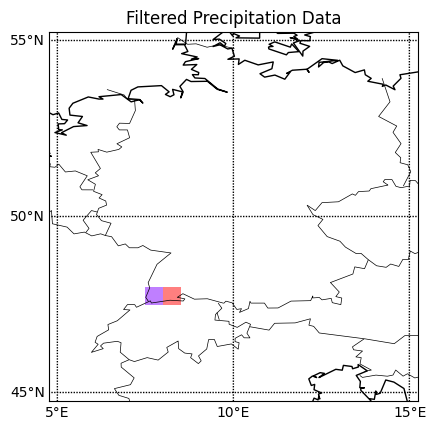

In [5]:
file_path = 'data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.2000.nc' 

nc_file = nc.Dataset(file_path)
lon = nc_file.variables['lon'][:]
lat = nc_file.variables['lat'][:]
data = nc_file.variables['tp'][50, :, :]  

# Mask data outside the polygon extent
lon_mask = (lon >= min_lon) & (lon <= max_lon)
lat_mask = (lat >= min_lat) & (lat <= max_lat)
data_masked = np.ma.masked_where(~np.outer(lat_mask, lon_mask), data)

# Create Basemap instance
m = Basemap(llcrnrlon=lon.min(), llcrnrlat=lat.min(),
            urcrnrlon=lon.max(), urcrnrlat=lat.max(),
            projection='cyl', resolution='l')

# Draw coastlines, countries, and states
m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Plot the filtered precipitation data as grid cells
x_mesh, y_mesh = np.meshgrid(lon, lat)
x_mesh, y_mesh = m(x_mesh, y_mesh)
plt.pcolormesh(x_mesh, y_mesh, data_masked, cmap='rainbow', alpha=0.5, label='Precipitation Data')

# Add latitude and longitude lines with labels
m.drawparallels(np.arange(-90., 91., 5.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 5.), labels=[0,0,0,1], fontsize=10)

plt.title('Filtered Precipitation Data')

# Show the plot
plt.show()

# Close the NetCDF file
nc_file.close()


In [6]:
# Find indices of lon and lat within the specified bounds
lon_idx = np.where((lon >= min_lon) & (lon <= max_lon))[0]
lat_idx = np.where((lat >= min_lat) & (lat <= max_lat))[0]

# Resulting indices
intersecting_lons = lon[lon_idx]
intersecting_lats = lat[lat_idx]

print("Longitude Indices:", lon_idx)
print("Latitude Indices:", lat_idx)
print("Intersecting Longitudes:", intersecting_lons)
print("Intersecting Latitudes:", intersecting_lats)

Longitude Indices: [6 7]
Latitude Indices: [15]
Intersecting Longitudes: [7.75 8.25]
Intersecting Latitudes: [47.75]


In [7]:
years = np.arange(2000,2024,1)

R_data = []
T_data = []
P_data = []
lai_data = []


for year in years:
    file_path = 'data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    P_data.append(xr.open_dataset(file_path)['tp'][:,lat_idx,lon_idx])

    file_path = 'data/net_radiation/nr.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    R_data.append(xr.open_dataset(file_path)['nr'][:,lat_idx,lon_idx])

    file_path = 'data/daily_average_temperature/t2m_mean.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    T_data.append(xr.open_dataset(file_path)['t2m'][:,lat_idx,lon_idx])

    file_path = 'data/lai/lai.daily.0d50_CentralEurope.' + str(year) + '.nc'
    lai_data.append(xr.open_dataset(file_path)['lai'][:,lat_idx,lon_idx])

In [8]:
years

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023])

In [9]:
# Convert lists to xarray datasets
P_data = xr.concat(P_data, dim='time')
R_data = xr.concat(R_data, dim='time')
T_data = xr.concat(T_data, dim='time')
lai_data = xr.concat(lai_data, dim='time')

In [10]:
# Fill LAI with zeros were Na :D (wrong)
lai_data = lai_data.fillna(0)

In [11]:
# Run model for all gridcells 1:30 min for one cell... there are 484 cells

import run

# Paramters
cs = 420 
alpha = 8 
gamma = 0.2 
beta = 0.8
cm = 1.5 
et_weight = (0.75, 0.25)

# Create empty arrays to store the output data
snow = np.zeros_like(P_data)
soil_moisture = np.zeros_like(P_data)
evapotranspiration = np.zeros_like(P_data)

# Iteerate through gridcels
for lat in range(len(P_data.lat)):
    for lon in range(len(P_data.lon)):
        
        if np.isnan(lai_data[:, lat, lon]).any():
            print("Na found in gridcell", lat, lon)
            continue

        R_data_grid = R_data[:, lat, lon]
        P_data_grid = P_data[:, lat, lon]
        T_data_grid = T_data[:, lat, lon]
        lai_data_grid = lai_data[:, lat, lon]

        # Run Model for daily values
        daily_output = run.time_evolution(P_data_grid, R_data_grid, T_data_grid, lai_data_grid, cs, alpha,
        gamma, beta, cm, et_weight)

        snow[:, lat, lon] = daily_output['snow'].values
        soil_moisture[:, lat, lon] = daily_output['calculated_soil_moisture'].values
        evapotranspiration[:, lat, lon] = daily_output['evapotranspiration'].values

In [50]:
# Convert arrays to xarrays with corresponding latitudes and longitudes
snow_xr_schwarzwald = xr.DataArray(snow, dims=('time', 'lat', 'lon'), coords={'time': P_data.time, 'lat': P_data.lat, 'lon': P_data.lon})
soil_moisture_xr_schwarzwald = xr.DataArray(soil_moisture, dims=('time', 'lat', 'lon'), coords={'time': P_data.time, 'lat': P_data.lat, 'lon': P_data.lon})
evapotranspiration_xr_schwarzwald = xr.DataArray(evapotranspiration, dims=('time', 'lat', 'lon'), coords={'time': P_data.time, 'lat': P_data.lat, 'lon': P_data.lon})

In [51]:
import xarray as xr

# Assuming snow_xr_schwarzwald, soil_moisture_xr_schwarzwald, and evapotranspiration_xr_schwarzwald are your xarray.DataArray objects

# Save each xarray.DataArray as a NetCDF file
snow_xr_schwarzwald.to_netcdf('data/snow_data_schwarzwald.nc')
soil_moisture_xr_schwarzwald.to_netcdf('data/soil_moisture_data_schwarzwald.nc')
evapotranspiration_xr_schwarzwald.to_netcdf('data/evapotranspiration_data_schwarzwald.nc')


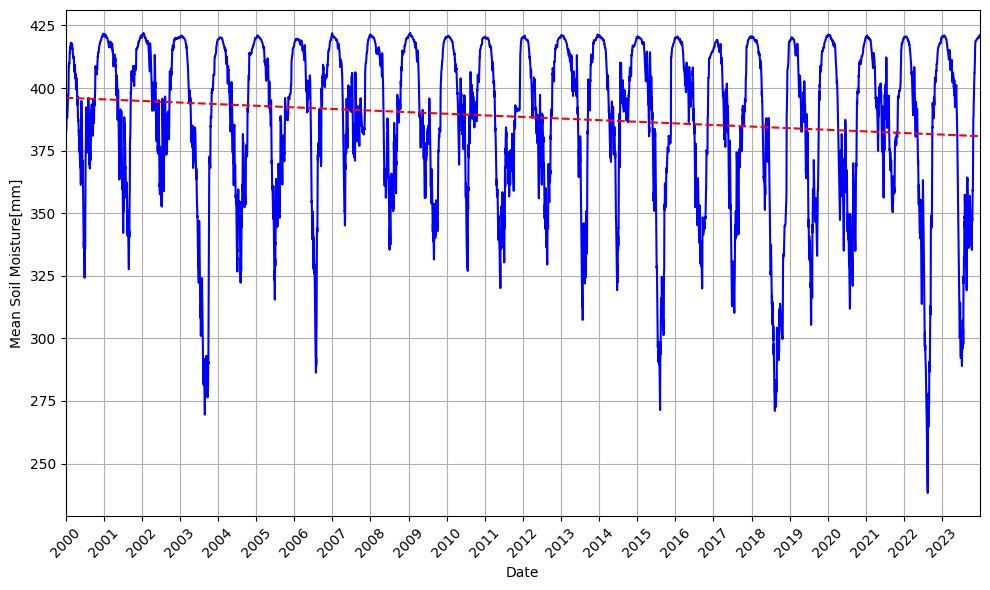

In [42]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr

# Assuming soil_moisture_xr is your xarray.DataArray

# Calculate the mean along the lat and lon axes (axis=1)
mean_soil_moisture = soil_moisture_xr.mean(dim=('lat', 'lon'))

# Plot the mean soil moisture
plt.figure(figsize=(10, 6))
plt.plot(mean_soil_moisture.time, mean_soil_moisture, color='blue', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Mean Soil Moisture[mm]')
plt.xticks(rotation=45)

# Set the x-axis limits to include only the years with data
plt.xlim(mean_soil_moisture.time.min(), mean_soil_moisture.time.max())

# Show every year on the x-axis based on the data
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.grid(True)
plt.tight_layout()
plt.show()


In [52]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr

# Read the NetCDF files into xarray.DataArray objects
snow_xr_schwarzwald = xr.open_dataarray('snow_data_schwarzwald.nc')
soil_moisture_xr_schwarzwald = xr.open_dataarray('soil_moisture_data_schwarzwald.nc')
evapotranspiration_xr_schwarzwald = xr.open_dataarray('evapotranspiration_data_schwarzwald.nc')

# Calculate the mean along the lat and lon axes (axis=1) for soil moisture
mean_soil_moisture = soil_moisture_xr_schwarzwald.mean(dim=('lat', 'lon'))

# Plot the mean soil moisture
plt.figure(figsize=(10, 6))
plt.plot(mean_soil_moisture.time, mean_soil_moisture, color='blue', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Mean Soil Moisture[mm]')
plt.xticks(rotation=45)

# Set the x-axis limits to include only the years with data
plt.xlim(mean_soil_moisture.time.min(), mean_soil_moisture.time.max())

# Show every year on the x-axis based on the data
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.grid(True)
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/justusnogel/Documents/applied_landsurface_modelling/deadwood_prediction/snow_data_schwarzwald.nc'

ValueError: x and y must have same first dimension, but have shapes (366,) and (2, 1, 366)

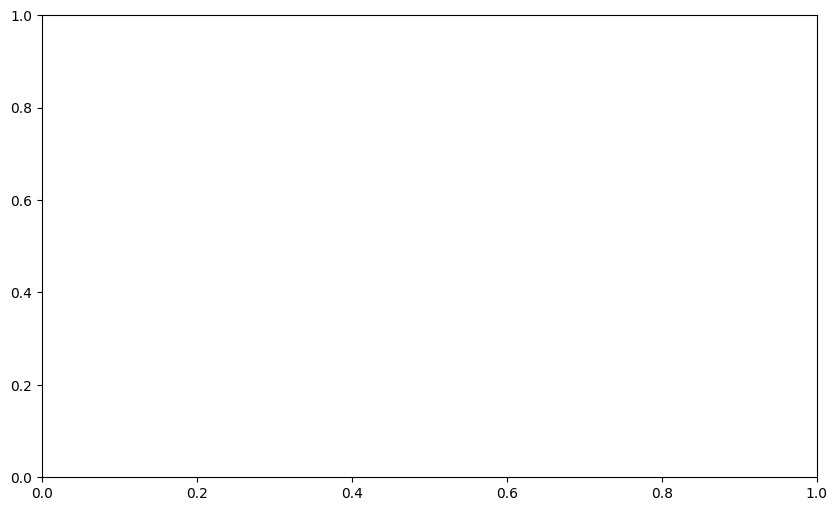

In [48]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr

# Assuming soil_moisture_xr is your xarray.DataArray

# Group the data by day and calculate the standard deviation for each day
daily_std = soil_moisture_xr.groupby('time.dayofyear').std(dim='time')

# Get the dates corresponding to each day of the year
dayofyear_dates = xr.DataArray(xr.cftime_range(start='2000-01-01', periods=366), dims=('dayofyear',))

# Reshape daily_std to have the same shape as dayofyear_dates
daily_std_reshaped = daily_std.assign_coords(dayofyear=dayofyear_dates)

# Plot the time series of daily standard deviation
plt.figure(figsize=(10, 6))
plt.plot(dayofyear_dates, daily_std_reshaped.T, color='blue', linestyle='-')  # Transpose daily_std_reshaped
plt.xlabel('Date')
plt.ylabel('Daily Standard Deviation of Soil Moisture[mm]')
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
import xarray as xr

# Assuming soil_moisture_xr is your xarray.DataArray

# Calculate the mean of soil_moisture_xr
mean_soil_moisture = soil_moisture_xr.mean()

# Calculate the standard deviation of soil_moisture_xr
std_soil_moisture = soil_moisture_xr.std()

print("Mean soil moisture:", mean_soil_moisture)
print("Standard deviation of soil moisture:", std_soil_moisture)


Mean soil moisture: <xarray.DataArray ()> Size: 8B
array(388.43708586)
Standard deviation of soil moisture: <xarray.DataArray ()> Size: 8B
array(33.24954898)


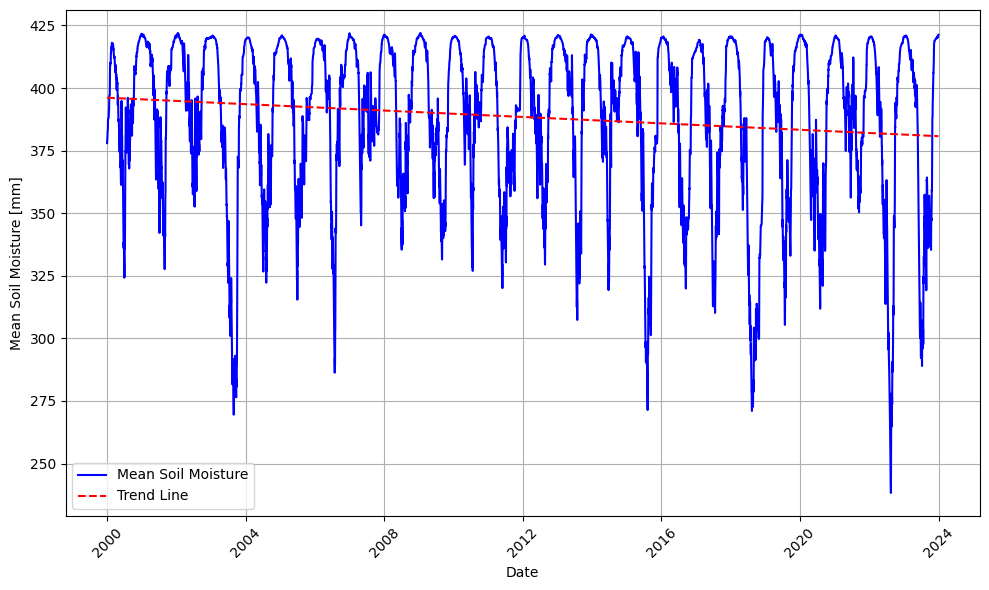

In [41]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
import numpy as np
from sklearn.linear_model import LinearRegression

# Assuming soil_moisture_xr is your xarray.DataArray

# Calculate the mean along the lat and lon axes (axis=1)
mean_soil_moisture = soil_moisture_xr.mean(dim=('lat', 'lon'))

# Convert time values to ordinal for regression
time_values = mdates.date2num(mean_soil_moisture.time)

# Fit a linear regression model
X = time_values.reshape(-1, 1)
y = mean_soil_moisture.values.reshape(-1, 1)
model = LinearRegression().fit(X, y)

# Predict the trend line
trend_line = model.predict(X)

# Plot the mean soil moisture and trend line
plt.figure(figsize=(10, 6))
plt.plot(mean_soil_moisture.time, mean_soil_moisture, color='blue', linestyle='-', label='Mean Soil Moisture')
plt.plot(mean_soil_moisture.time, trend_line, color='red', linestyle='--', label='Trend Line')
plt.xlabel('Date')
plt.ylabel('Mean Soil Moisture [mm]')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


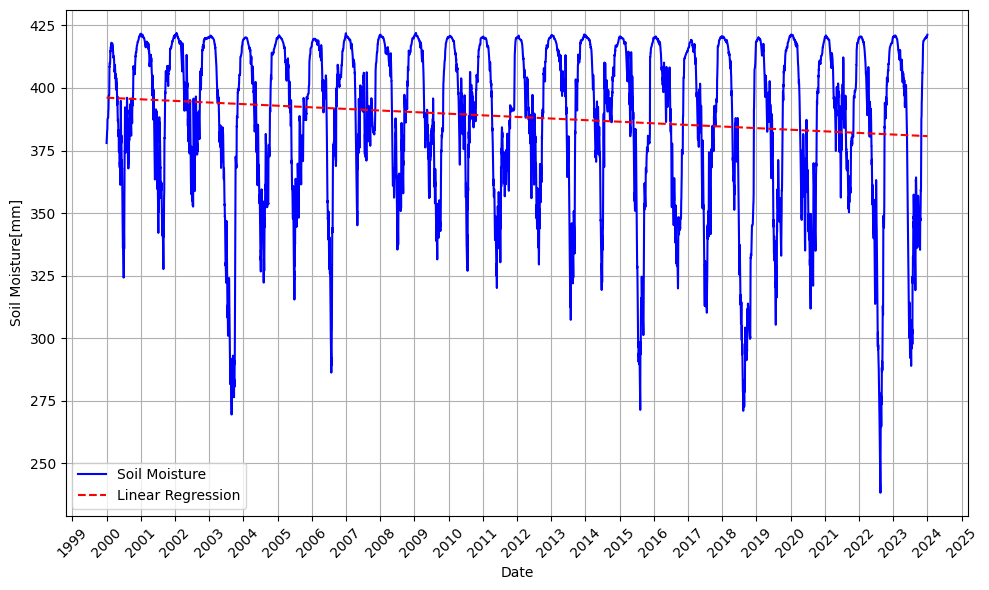

In [38]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from sklearn.linear_model import LinearRegression
import os

# Assuming soil_moisture_xr is your xarray.DataArray

# Calculate the mean along the lat and lon axes (axis=1)
mean_soil_moisture = soil_moisture_xr.mean(dim=('lat', 'lon'))

# Plot the mean soil moisture
plt.figure(figsize=(10, 6))
plt.plot(mean_soil_moisture.time, mean_soil_moisture, color='blue', linestyle='-', label='Soil Moisture')
plt.xlabel('Date')
plt.ylabel('Soil Moisture[mm]')
plt.xticks(rotation=45)

# Show every year on the x-axis
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

# Extracting time and soil moisture values as numpy arrays
time_values = mean_soil_moisture.time.values.astype('datetime64[D]').astype(float)  # Converting to float for LinearRegression
soil_moisture_values = mean_soil_moisture.values

# Fitting a linear regression model
model = LinearRegression()
model.fit(time_values.reshape(-1, 1), soil_moisture_values)

# Predicting values using the fitted model
predicted_values = model.predict(time_values.reshape(-1, 1))

# Plotting the linear regression line
plt.plot(mean_soil_moisture.time, predicted_values, color='red', linestyle='--', label='Linear Regression')

plt.grid(True)
plt.tight_layout()
plt.legend()

# Define the path to the results folder in your cloned GitHub repository
results_folder_path = "results"

# Check if the results folder exists, if not, create it
if not os.path.exists(results_folder_path):
    os.makedirs(results_folder_path)

# Define the filename for the exported image
image_filename = os.path.join(results_folder_path, "soil_moisture_regression_plot.pdf")

# Export the plot as vector data (PDF)
plt.savefig(image_filename, format='svg')

# Show the plot
plt.show()


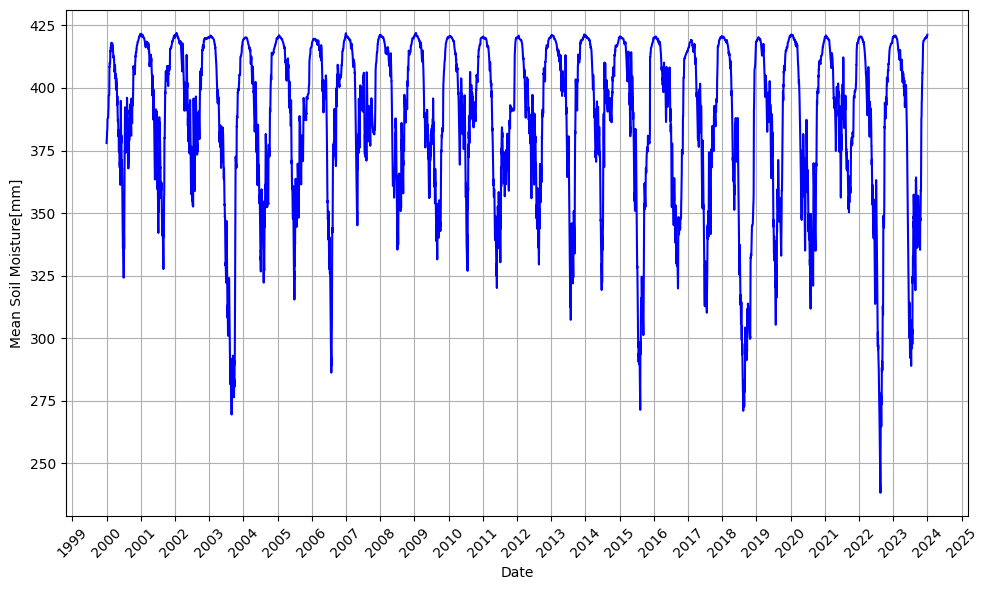

In [36]:
import matplotlib.pyplot as plt
import xarray as xr

# Assuming soil_moisture_xr is your xarray.DataArray

# Calculate the mean along the lat and lon axes (axis=1)
mean_soil_moisture = soil_moisture_xr.mean(dim=('lat', 'lon'))

# Plot the mean soil moisture
plt.figure(figsize=(10, 6))
plt.plot(mean_soil_moisture.time, mean_soil_moisture, color='blue', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Mean Soil Moisture[mm]')
plt.xticks(rotation=45)

# Show every year on the x-axis
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

plt.grid(True)
plt.tight_layout()
plt.show()



In [34]:
import matplotlib.pyplot as plt
import xarray as xr

# Assuming soil_moisture_xr is your xarray.DataArray

# Calculate the mean along the lat and lon axes (axis=1)
mean_soil_moisture = soil_moisture_xr.mean(dim=('lat', 'lon'))

import pandas as pd

# Convert the min and max years to datetime
start_date = pd.to_datetime(str(mean_soil_moisture.time.dt.year.min().values + 1))
end_date = pd.to_datetime(str(mean_soil_moisture.time.dt.year.max().values - 1))

# Exclude the first and last year
mean_soil_moisture = mean_soil_moisture.sel(time=slice(start_date, end_date))

# Exclude the first and last year
mean_soil_moisture = mean_soil_moisture.sel(time=slice(mean_soil_moisture.time.dt.year.min() + 1, mean_soil_moisture.time.dt.year.max() - 1))

# Plot the mean soil moisture
plt.figure(figsize=(10, 6))
plt.plot(mean_soil_moisture.time, mean_soil_moisture, color='blue', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Mean Soil Moisture[mm]')
plt.xticks(rotation=45)

# Show every year on the x-axis
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

plt.grid(True)
plt.tight_layout()
plt.show()

TypeError: cannot do slice indexing on DatetimeIndex with these indexers [2002] of type int64

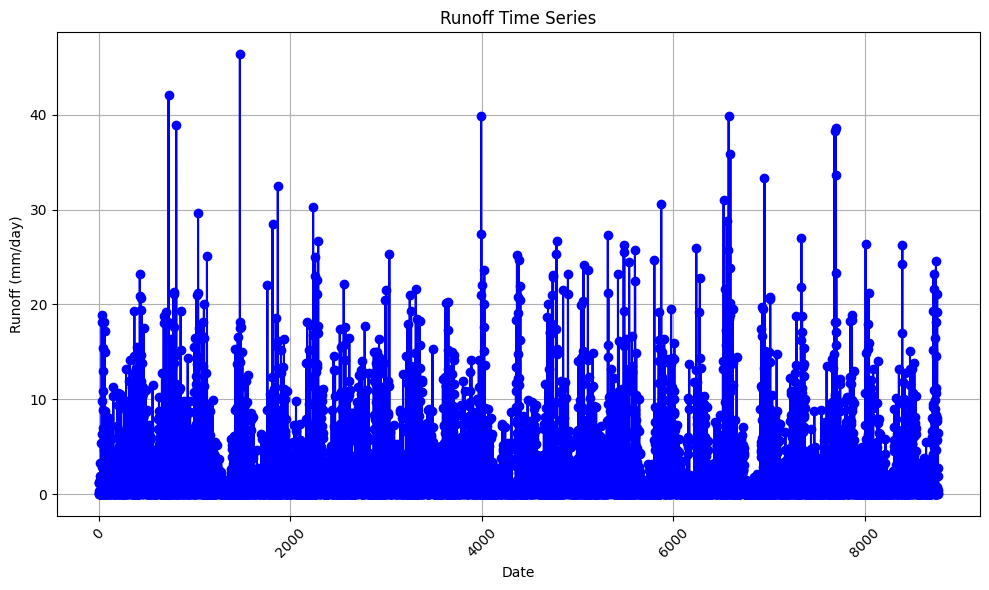

In [13]:
import matplotlib.pyplot as plt

# Assuming daily_output['calculated_soil_moisture'] contains the soil moisture values
soil_moisture_xr = daily_output['runoff']


# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(soil_moisture_xr, color='blue', marker='o', linestyle='-')
plt.title('Runoff Time Series')
plt.xlabel('Date')
plt.ylabel('Runoff (mm/day)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


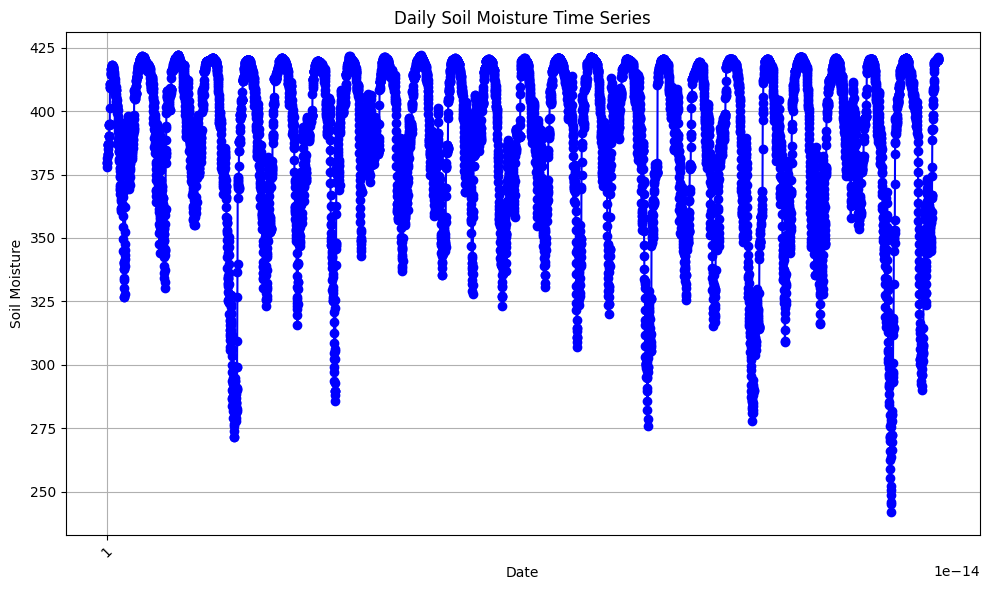

In [14]:
import matplotlib.pyplot as plt

# Assuming daily_output['calculated_soil_moisture'] contains the soil moisture values
soil_moisture_values = daily_output['calculated_soil_moisture']

# Assuming daily_output['time'] contains the corresponding timestamps
timestamps = daily_output['time']

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(timestamps, soil_moisture_values, color='blue', marker='o', linestyle='-')
plt.title('Daily Soil Moisture Time Series')
plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.xticks(rotation=45)

# Customize the x-axis ticks to show only the first of January for each year
plt.xticks(pd.date_range(timestamps.min(), timestamps.max(), freq='YS'), rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()


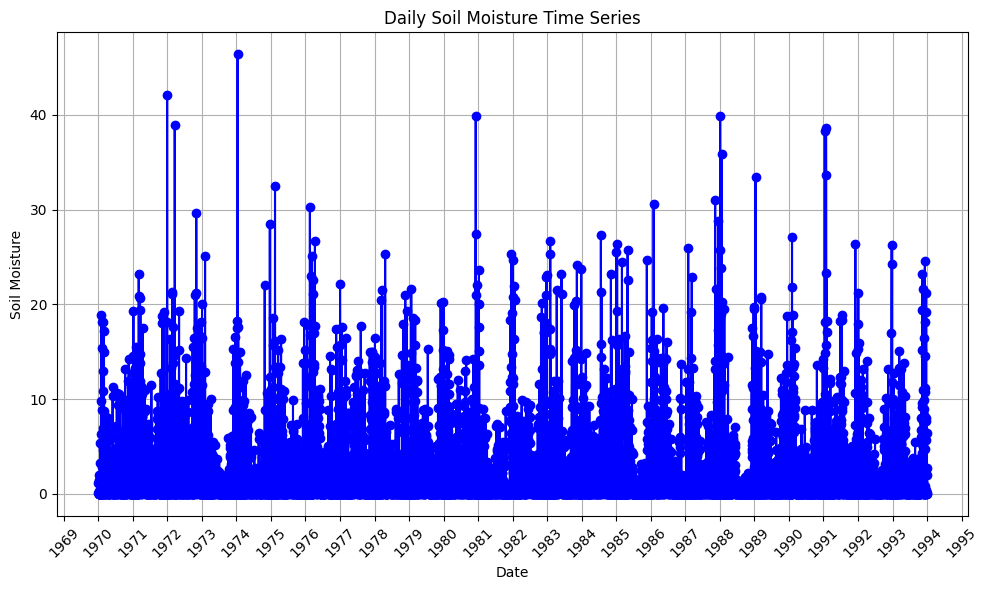

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming daily_output['calculated_soil_moisture'] contains the soil moisture values
soil_moisture_xr = daily_output['runoff']

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(soil_moisture_xr, color='blue', marker='o', linestyle='-')
plt.title('Daily Soil Moisture Time Series')
plt.xlabel('Date')
plt.ylabel('Soil Moisture')

# Format the x-axis to show year markers
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show() 